In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pickle
from typing import Tuple, List, Any, Dict
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

In [2]:
def get_embeddings(data: List[Dict[str, np.ndarray]], atom_number, sample_limit=10000) -> np.ndarray:
    embeddings = []

    for molecule in data:
        for idx in range(len(molecule["atom_numbers"])):
            if molecule["atom_numbers"][idx] == atom_number:
                embd = molecule["embeddings"][idx]
                embeddings.append(embd)

                if (sample_limit is not None) and (len(embeddings) >= sample_limit):
                    return np.array(embeddings)

    return np.array(embeddings)

HYDROGEN = 1
CARBON = 6
NITROGEN = 7
OXYGEN = 8

atom_map = {
    HYDROGEN: "Hydrogen",
    CARBON: "Carbon",
    NITROGEN: "Nitrogen",
    OXYGEN: "Oxygen"
}

MODEL_NAME = "lumo"
CHOSEN_ATOM = CARBON

In [3]:

num_rows, num_columns = 7, 7

model_data = [
    "./data/outputs_homo_model.pkl",
    "./data/outputs_lumo_model.pkl",
    "./data/outputs_homo_lumo_model.pkl",
    "./data/outputs_TL_homo_lumo_model.pkl",
    "./data/outputs_TL_lumo_homo_model.pkl",
    "./data/outputs_TLF_homo_lumo_model.pkl",
    "./data/outputs_TLF_lumo_homo_model.pkl"
]

model_labels = [
    "homo",
    "lumo",
    "homo_lumo",
    "TL_homo_lumo",
    "TL_lumo_homo",
    "TLF_homo_lumo",
    "TLF_lumo_homo"
]

# model_data = [
#     "./data/outputs_Cv_model.pkl",
#     "./data/outputs_zpve_model.pkl",
#     "./data/outputs_Cv_zpve_model.pkl",
#     "./data/outputs_TL_Cv_zpve_model.pkl",
#     "./data/outputs_TL_zpve_Cv_model.pkl",
#     "./data/outputs_TLF_Cv_zpve_model.pkl",
#     "./data/outputs_TLF_zpve_Cv_model.pkl"
# ]

# model_labels = [
#     "Cv",
#     "zpve",
#     "Cv_zpve",
#     "TL_Cv_zpve",
#     "TL_zpve_Cv",
#     "TLF_Cv_zpve",
#     "TLF_zpve_Cv"
# ]

data = []
for i in range(len(model_data)):
    file_path = f"{model_data[i]}"
    with open(file_path, "rb") as f:
        cell_data = pickle.load(f)
    data.append(get_embeddings(cell_data, CHOSEN_ATOM, sample_limit=None))

data = np.array(data)

print(data.shape)


(7, 10370, 32)


In [4]:
cosine_similarities = []

with tqdm(total=num_rows * num_columns * data.shape[1]) as pbar:
    for i in range(num_rows):
        for j in range(num_columns):
            for k in range (data.shape[1]):
                similarity = cosine_similarity(data[i,k].reshape(1, -1), data[j,k].reshape(1, -1))
                cosine_similarities.append(similarity)
                pbar.update(1)

cosine_similarities = np.array(cosine_similarities).reshape(num_rows, num_columns, -1)
print(cosine_similarities.shape)


100%|██████████| 508130/508130 [01:42<00:00, 4937.99it/s]


(7, 7, 10370)


In [5]:
for i in range(num_rows):
    for j in range(num_columns):
        print(f"({i}, {j}): {cosine_similarities[i,j].min()}, {cosine_similarities[i,j].max()}")


(0, 0): 0.9999997615814209, 1.000000238418579
(0, 1): 0.8761548399925232, 0.9846201539039612
(0, 2): 0.8286737203598022, 0.9799939393997192
(0, 3): 0.7962650060653687, 0.9823575615882874
(0, 4): 0.6890212297439575, 0.9761906862258911
(0, 5): 0.9999997615814209, 1.000000238418579
(0, 6): 0.8761548399925232, 0.9846201539039612
(1, 0): 0.8761548399925232, 0.9846201539039612
(1, 1): 0.9999997019767761, 1.000000238418579
(1, 2): 0.8045625686645508, 0.9898656010627747
(1, 3): 0.7191003561019897, 0.9772323369979858
(1, 4): 0.7760024070739746, 0.9805058240890503
(1, 5): 0.8761548399925232, 0.9846201539039612
(1, 6): 0.9999997019767761, 1.000000238418579
(2, 0): 0.8286737203598022, 0.9799939393997192
(2, 1): 0.8045625686645508, 0.9898656010627747
(2, 2): 0.9999997019767761, 1.0000003576278687
(2, 3): 0.6029911637306213, 0.9715671539306641
(2, 4): 0.7315208315849304, 0.9729020595550537
(2, 5): 0.8286737203598022, 0.9799939393997192
(2, 6): 0.8045625686645508, 0.9898656010627747
(3, 0): 0.7962650

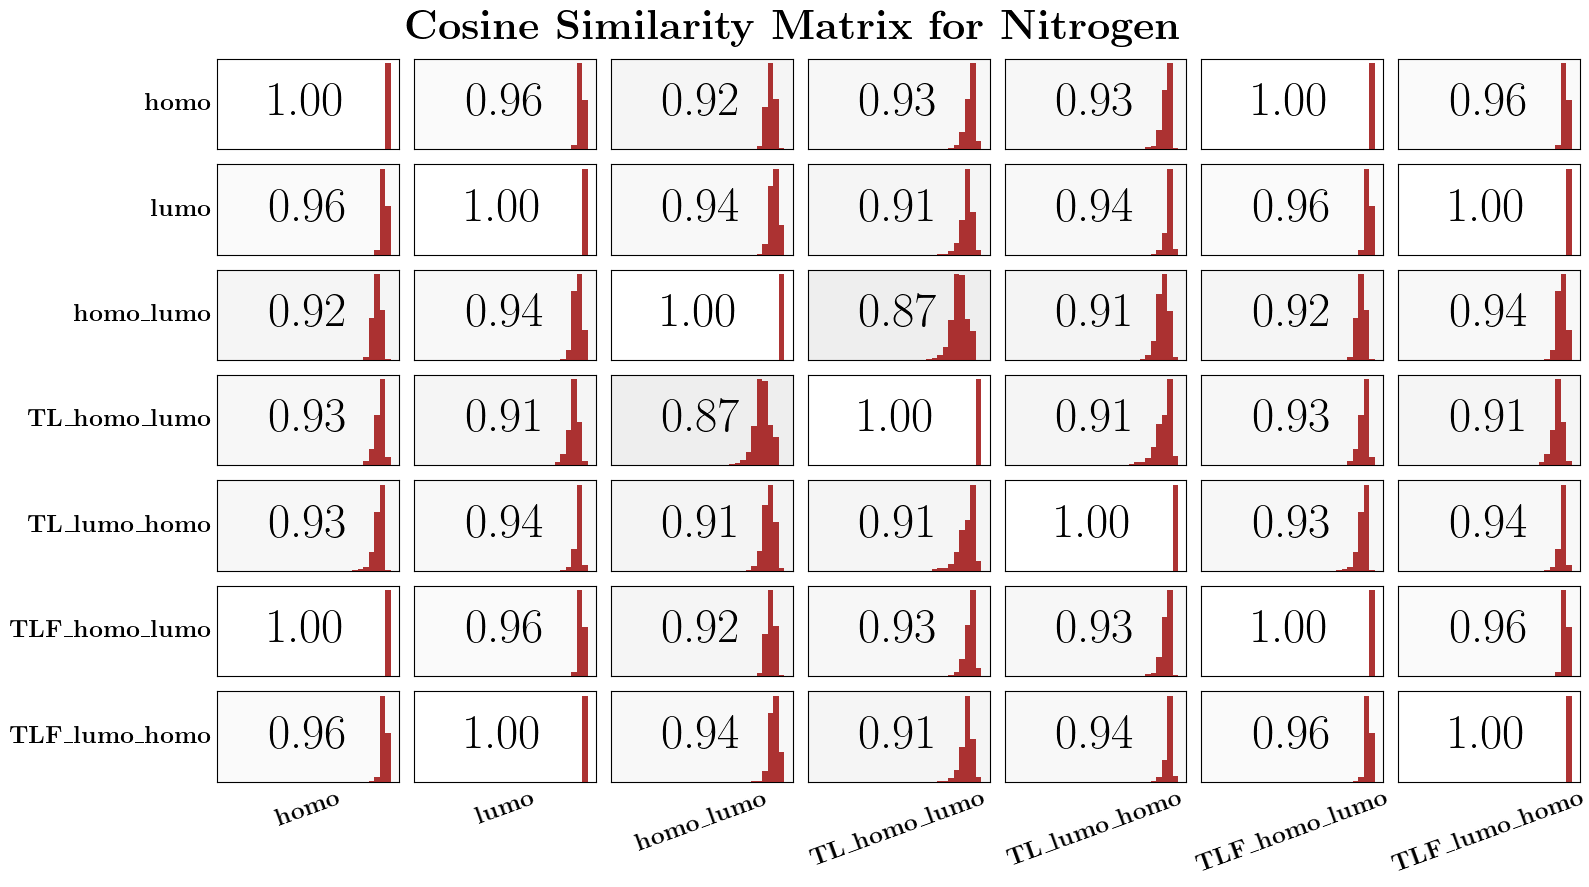

M1: ./data/outputs_homo_model.pkl
M2: ./data/outputs_lumo_model.pkl
M3: ./data/outputs_homo_lumo_model.pkl
M4: ./data/outputs_TL_homo_lumo_model.pkl
M5: ./data/outputs_TL_lumo_homo_model.pkl
M6: ./data/outputs_TLF_homo_lumo_model.pkl
M7: ./data/outputs_TLF_lumo_homo_model.pkl


In [7]:
num_bins = 30
DTU_RED = "#990000"
from matplotlib import cm

figure, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(16, 9))
plt.rc('text', usetex=True)
plt.rc('font', family='serif') 

for i in range(num_rows):
    for j in range(num_columns):
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

        mean_str = f"{cosine_similarities[i, j].mean():.2f}"
        tex_str = r"\textbf{" + mean_str + "}"
        
        color = cm.Greys_r(cosine_similarities[i, j].mean())
        axes[i, j].set_facecolor(color)

        axes[i, j].text(0.5, 0.5, mean_str,
                         horizontalalignment='center', 
                         verticalalignment='center', 
                         transform=axes[i, j].transAxes, 
                         color='black',
                         fontsize=35,
                         zorder=10)
        axes[i, j].hist(cosine_similarities[i, j], 
                        bins=num_bins, 
                        range=(0, 1), 
                        color=DTU_RED, 
                        zorder=9,
                        alpha=0.8)
        
        if j == 0:
            ylabel_str = model_labels[i]
            axes[i, j].set_ylabel(r"\textbf{" + ylabel_str + "}", rotation=0, ha='right', va='center', fontsize=18)
        
        if i == num_rows - 1:
            xlabel_str = model_labels[j]
            axes[i, j].set_xlabel(r"\textbf{" + xlabel_str + "}", fontsize=18, rotation=20)


# Adjust the spacing
plt.subplots_adjust(hspace=0.05, wspace=0.05)
title_str = f"Cosine Similarity Matrix for {atom_map[CHOSEN_ATOM]}"
figure.suptitle(r"\textbf{" + title_str + "}", fontsize=30)
figure.tight_layout()


# Show the plot
plt.savefig(f"./plots/similarity_matrix_{atom_map[CHOSEN_ATOM].lower()}_{MODEL_NAME}.pdf", bbox_inches='tight')
plt.show()

for idx, m in enumerate(model_data):
    print(f"M{idx+1}: {m}")
